In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import time
import pickle
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal as mltnorm
from scipy.sparse import csr_matrix
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
%matplotlib inline

In [2]:
from functions import *

In [3]:
from algorithms_comp import *

In [4]:
from utils import *

# Negative log-likelihood

## a9a

In [5]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions in the sum: ", m, ", dimension of the problem: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness constant of the sum: ", L)
print("Average smoothness constant   : ", average_L)
print("Worst smoothness constant     : ", worst_L)
print("Fraction of non-zero elemenst : ", sparsity_A)

Number of functions in the sum:  32561 , dimension of the problem:  123
Smoothness constant of the sum:  1.5719196992226567
Average smoothness constant   :  3.467276803535652
Worst smoothness constant     :  3.5
Fraction of non-zero elemenst :  0.11275696922074716
CPU times: total: 391 ms
Wall time: 389 ms


### Find the solution

In [6]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [7]:
%%time
param = [A, y, l2, False]
res_solver = minimize(negative_loglikelihood_loss, x_init, args = param, jac=negative_loglikelihood_loss_grad, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-10)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

ValueError: failed in converting 7th argument `g' of _lbfgsb.setulb to C/Fortran array

In [11]:
l2 = 0
l1 = 0
sparse = False
sparse_full = True


bs = 100

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 100.0
x_init[0:num_of_non_zeros] += shift_param
N = 50

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)
delta = 0
t = 1e-3
param = [negative_loglikelihood_loss, A, y, l2, sparse, sparse_full, L, delta, t]


print("f(x_0)-f(x^*) = ", negative_loglikelihood_loss(x_init, [A, y, l2, False, t]) - f_star)
epsilon = 1e-3

f(x_0)-f(x^*) =  -0.8820145999191751


In [12]:
%%time
# tuning_stepsize_param_options_ardfds_e = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-1]
batchsizes = [10000]
for step_param in stepsizes:
    for bs in batchsizes: 
        Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished with lr = {} and bs = {}'.format(step_param, bs))

  0%|          | 0/162 [00:00<?, ?it/s]

100%|██████████| 162/162 [00:25<00:00,  6.31it/s]

Finished with lr = 0.1 and bs = 10000
CPU times: total: 31.2 s
Wall time: 25.7 s


FileNotFoundError: [Errno 2] No such file or directory: 'dump/a9a_init_first_1_shift_100.0Our_algorithm0.1_epochs_50_delta_0_batch_10000.txt'

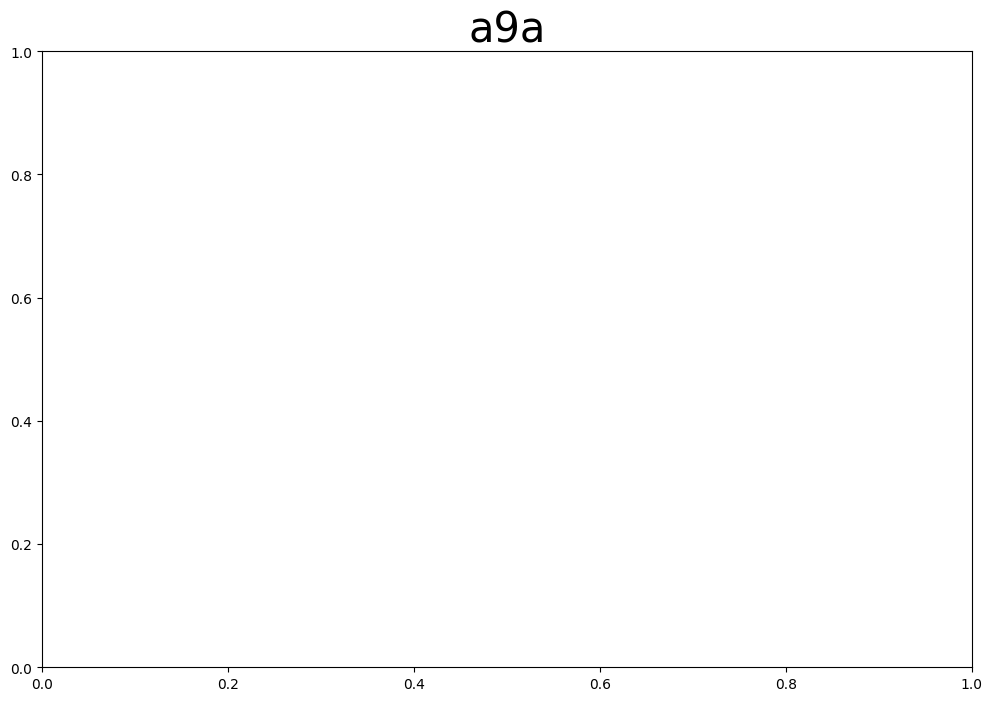

In [13]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-1]
batchsizes = [10000]
for step_param, bs in zip(stepsizes, batchsizes):
    methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {step_param}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)